In [1]:
!git clone -b alex "https://github.com/ab7289-tandon-nyu/csgy6953_DeepLearning_Midterm.git"
!cp -r /content/csgy6953_DeepLearning_Midterm/src/ .

fatal: destination path 'csgy6953_DeepLearning_Midterm' already exists and is not an empty directory.


In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import time
import copy
import random

In [3]:
SEED = 1234

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
from src.data import get_transformed_data, make_data_loaders
from src.transforms import make_auto_transforms

BATCH_SIZE = 256
valid_ration = 0.1

train_iter, valid_iter, test_iter = (
    make_data_loaders(
        *get_transformed_data(
            make_transforms= make_auto_transforms,
            valid_ratio= valid_ration
        ),
        batch_size=BATCH_SIZE,
    )
)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [5]:
from src.model import ResNet, StemConfig, ResidualBlockType
from src.utils import initialize_parameters

arch = [
    (ResidualBlockType.BOTTLENECK, 2, 128, 0.1),
    (ResidualBlockType.BOTTLENECK, 6, 256, 0.1),
    (ResidualBlockType.BOTTLENECK, 6, 512, 0.1),
    (ResidualBlockType.BOTTLENECK, 2, 1024, 0.1),
]

config = StemConfig(num_channels=128, kernel_size=3, stride=1, padding=1)
model = ResNet(arch, stem_config=config, output_size=10, use_bias=True)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [6]:
print("Initializing new model")
inputs = torch.ones((BATCH_SIZE, 3, 32, 32))
model = model.to(device)
y = model(inputs.to(device))
print(y.size())

model.apply(initialize_parameters)

Initializing new model
torch.Size([256, 10])


ResNet(
  (stem): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): AdaptiveAvgPool2d(output_size=1)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=1024, out_features=10, bias=True)
  )
  (body): Sequential(
    (block_2): Sequential(
      (0): BottleneckResidualBlock(
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
        (conv1): Conv2d(128, 32, kernel_size=(1, 1), stride=(1, 1))
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
 

In [7]:
import math

best_loss = float('inf')
EPOCHS = 3
# max_lr = 0.75 # potential best 0.45]
# also look at range 1 - 1.4 for b256
max_lr = 0.2
start_lr = 0.001

print(f"Number of iterations: {EPOCHS * len(train_iter)}")
print(f"Step Size: {(max_lr - start_lr) / (EPOCHS * len(train_iter))}")

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=start_lr)

def lin_lambda(x):
  return (x * (max_lr - start_lr) / (EPOCHS * len(train_iter))) / start_lr
lr_lambda = lambda x: math.exp(x * math.log(max_lr / start_lr) / (EPOCHS * len(train_iter)))
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lin_lambda)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

Number of iterations: 528
Step Size: 0.0003768939393939394


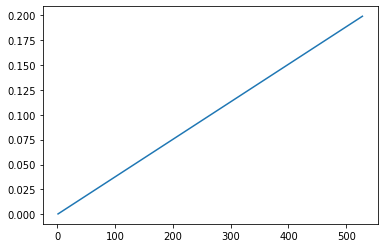

In [8]:
lamb = lambda x: lin_lambda(x) * start_lr

lin = [i+1 for i in range(EPOCHS * len(train_iter))]
nil = list(map(lamb, lin))
plt.plot(lin, nil)
plt.show()

In [9]:
"https://towardsdatascience.com/adaptive-and-cyclical-learning-rates-using-pytorch-2bf904d18dee"

lr_stats = []
acc_stats = []
loss_stats = []

smoothing = 0.05
iter = 0
model.train()
for i in range(1, EPOCHS+1):
    for x,y in train_iter:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        outputs = model(x)
        loss = criterion(outputs, y)

        loss.backward()
        optimizer.step()

        scheduler.step()
        acc_stats.append((outputs.argmax(1) == y).sum().item())

        lr_stats.append(optimizer.state_dict()["param_groups"][0]["lr"])

        if iter == 0:
            loss_stats.append(loss.item())
        else:
            # apply smoothing
            smooth_loss = smoothing * loss.item() + (1 - smoothing) * loss_stats[-1]
            loss_stats.append(smooth_loss)

        # print(f"iter: {iter}\nLR: {lr_stats[-1]}, Loss: {loss_stats[-1]}, Acc: {acc_stats[-1]}")
        # print(f"Get last LR: {scheduler.get_last_lr()}")
        iter += 1


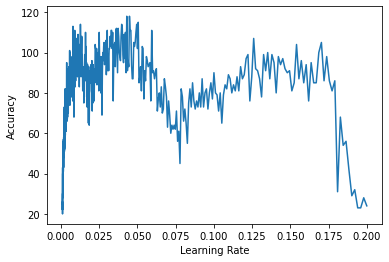

In [10]:
# add matplot lib graph
plt.plot(lr_stats, acc_stats)
plt.ylabel("Accuracy")
plt.xlabel("Learning Rate")
plt.show()

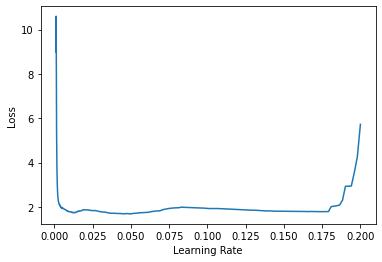

In [11]:
plt.plot(lr_stats, loss_stats)
plt.ylabel("Loss")
plt.xlabel("Learning Rate")
plt.show()

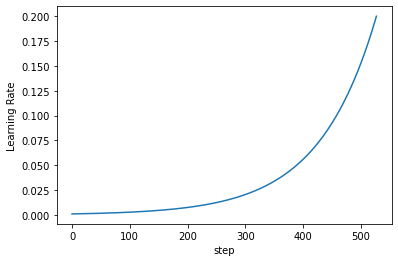

In [12]:
plt.plot([i for i in range(iter)], lr_stats)
plt.ylabel("Learning Rate")
plt.xlabel("step")
plt.show()